# Import important library

In [1]:
import os
import cv2
import zipfile
import random
import tempfile
import numpy as np
from tqdm.auto import tqdm
from random import shuffle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# set manual seed
torch.manual_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Download dataset from kaggle

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# upload kaggle id
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"huyg1108","key":"25e2cf9284e14fb9ed253fa22c5f6797"}'}

In [ ]:
# go to directory that you want to save
%cd /content/drive/MyDrive/BrainTumorMRI
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# download dataset
!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

In [ ]:
!unzip "/content/drive/MyDrive/BrainTumorMRI/brain-tumor-mri-images-44c.zip" -d "/content/drive/MyDrive/BrainTumorMRI"

# Preprocessing dataset

In [3]:
data_path = '/content/drive/MyDrive/BrainTumorMRI/brain-tumor-mri-images'

train_path = '/content/drive/MyDrive/BrainTumorMRI/train'
val_path = '/content/drive/MyDrive/BrainTumorMRI/val'
test_path = '/content/drive/MyDrive/BrainTumorMRI/test'

classes = ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma',
           'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma',
           'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', '_NORMAL']

modalities = ['T1', 'T1C+', 'T2']

## Split data into 3 sets

In [ ]:
import shutil

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the percentage of data to use for the training, validation, and test sets
train_percent = 0.7
val_percent = 0.2
test_percent = 0.1

# Iterate over the classes and modalities in the dataset
for cls in classes:
    for modality in modalities:
        # Set the path to the folder for this class and modality
        file_name = cls + ' ' + modality
        folder = os.path.join(data_path, file_name)
        # Skip the folder if it doesn't exist
        if not os.path.isdir(folder):
            continue
        # Get a list of all the file names in the folder
        files = os.listdir(folder)
        # Shuffle the file names randomly
        random.shuffle(files)
        # Calculate the number of files to use for each set
        num_train = int(len(files) * train_percent)
        num_val = int(len(files) * val_percent)
        num_test = int(len(files) * test_percent)
        # Split the files into training, validation, and test sets
        train_files = files[:num_train]
        val_files = files[num_train:num_train+num_val]
        test_files = files[num_train+num_val:num_train+num_val+num_test]
        # Copy the files to the corresponding set folders and assign class labels
        for file in train_files:
            src_path = os.path.join(folder, file)
            dst_path = os.path.join(train_path, cls, modality, file)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)
        for file in val_files:
            src_path = os.path.join(folder, file)
            dst_path = os.path.join(val_path, cls, modality, file)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)
        for file in test_files:
            src_path = os.path.join(folder, file)
            dst_path = os.path.join(test_path, cls, modality, file)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)

## Print 10 random samples

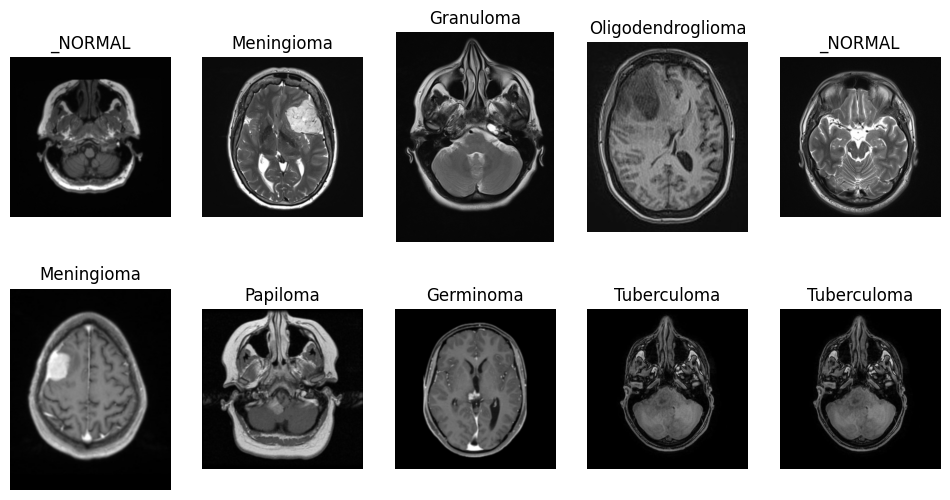

In [ ]:
# Initialize a figure and axes objects for plotting the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    # Choose a random class and modality
    cls = random.choice(classes)
    # Get a list of all the files for this class and modality
    files = os.listdir(os.path.join(train_path, cls))
    # Choose a random file
    file = random.choice(files)
    # Load and plot the image
    img = plt.imread(os.path.join(train_path, cls, file))
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(cls)
    axes[i].axis("off")

plt.show()

In [22]:
# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [23]:
# Define the dataset
train_data = ImageFolder(root='/content/drive/MyDrive/BrainTumorMRI/train', transform=train_transform)
val_data = ImageFolder(root='/content/drive/MyDrive/BrainTumorMRI/val', transform=transform)
test_data = ImageFolder(root='/content/drive/MyDrive/BrainTumorMRI/test', transform=transform)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [38]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


# Create model

## Model structure

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [64]:
class BrainTumorModelV0(nn.Module):
    def __init__(self):
        super(BrainTumorModelV0, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256 * 14 * 14, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2),

            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2),
            
            nn.Linear(in_features=256, out_features=15)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [65]:
model = BrainTumorModelV0().to(device)

In [66]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary

batch_size = 32
summary(model, input_size=[batch_size, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
BrainTumorModelV0                        [32, 15]                  --
├─Sequential: 1-1                        [32, 256, 14, 14]         --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 224, 224]        64
│    └─LeakyReLU: 2-3                    [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 112, 112]        128
│    └─LeakyReLU: 2-7                    [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 56, 56]         256
│    └─LeakyReLU: 2-11                   [32, 128, 56, 56]         --
│   

## Define loss and optimizer

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Create train loop

In [62]:
# Train the model
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=10):
    best_val_loss = float('inf')
    counter = 0

    # Create results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero out gradients
            optimizer.zero_grad()
            
            # Forward pass
            train_pred = model(images)
            loss = criterion(train_pred, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate loss & accuracy
            train_loss += loss.item()

            train_pred_labels = torch.argmax(torch.softmax(train_pred, dim=1), dim=1)
            train_acc += (train_pred_labels == labels).sum().item()/len(train_pred)

        # Calculate average train loss for the epoch
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Calculate validation loss for early stopping
        model.eval()
        val_acc = 0.0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, total=len(val_loader)):
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                val_pred = model(images)
                loss = criterion(val_pred, labels)
                
                # Accumulate loss & accuracy
                val_loss += loss.item()

                val_pred_labels = val_pred.argmax(dim=1)
                val_acc += ((val_pred_labels == labels).sum().item()/len(val_pred_labels))
        
        # Calculate average validation loss
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        # Print information for each epoch
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            counter += 1
            
        # Check if we should stop training due to no improvement in validation loss
        if counter >= patience:
            print(f"Validation loss did not improve for {patience} epochs. Training stopped.")
            break
    return results

## Train

In [68]:
# Define epochs 
epochs = 1000

# Number of epochs to break when model has no improvement
patience = 10

model_result = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs, patience=patience)

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0599 | train_acc: 0.3602 | val_loss: 1.5254 | val_acc: 0.4963


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.6383 | train_acc: 0.4777 | val_loss: 1.2958 | val_acc: 0.6012


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.3543 | train_acc: 0.5717 | val_loss: 0.8882 | val_acc: 0.7444


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.1921 | train_acc: 0.6270 | val_loss: 0.7568 | val_acc: 0.7653


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.0560 | train_acc: 0.6714 | val_loss: 0.6587 | val_acc: 0.8021


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.9815 | train_acc: 0.7013 | val_loss: 0.4706 | val_acc: 0.8661


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.8211 | train_acc: 0.7486 | val_loss: 0.4426 | val_acc: 0.8668


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.8254 | train_acc: 0.7357 | val_loss: 0.4070 | val_acc: 0.8906


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.7557 | train_acc: 0.7659 | val_loss: 0.4117 | val_acc: 0.8854


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.6753 | train_acc: 0.7968 | val_loss: 0.4165 | val_acc: 0.8776


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.6878 | train_acc: 0.7840 | val_loss: 0.3801 | val_acc: 0.8936


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.6841 | train_acc: 0.7837 | val_loss: 0.5249 | val_acc: 0.8411


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.6317 | train_acc: 0.7941 | val_loss: 0.3492 | val_acc: 0.8906


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.6131 | train_acc: 0.8028 | val_loss: 0.2756 | val_acc: 0.9129


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.5602 | train_acc: 0.8309 | val_loss: 0.3277 | val_acc: 0.8962


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.5705 | train_acc: 0.8251 | val_loss: 0.4027 | val_acc: 0.8746


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.5752 | train_acc: 0.8206 | val_loss: 0.2644 | val_acc: 0.9219


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.5510 | train_acc: 0.8281 | val_loss: 0.2285 | val_acc: 0.9286


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.5134 | train_acc: 0.8380 | val_loss: 0.2897 | val_acc: 0.9129


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.5163 | train_acc: 0.8416 | val_loss: 0.2960 | val_acc: 0.9148


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 21 | train_loss: 0.4707 | train_acc: 0.8594 | val_loss: 0.2197 | val_acc: 0.9330


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 22 | train_loss: 0.4958 | train_acc: 0.8463 | val_loss: 0.2799 | val_acc: 0.9089


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 23 | train_loss: 0.4932 | train_acc: 0.8436 | val_loss: 0.2306 | val_acc: 0.9308


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 24 | train_loss: 0.4715 | train_acc: 0.8541 | val_loss: 0.2140 | val_acc: 0.9353


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 25 | train_loss: 0.4776 | train_acc: 0.8474 | val_loss: 0.2371 | val_acc: 0.9353


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 26 | train_loss: 0.4510 | train_acc: 0.8588 | val_loss: 0.4226 | val_acc: 0.8806


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 27 | train_loss: 0.4520 | train_acc: 0.8584 | val_loss: 0.2812 | val_acc: 0.9219


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 28 | train_loss: 0.4526 | train_acc: 0.8600 | val_loss: 0.2302 | val_acc: 0.9397


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 29 | train_loss: 0.4376 | train_acc: 0.8588 | val_loss: 0.2341 | val_acc: 0.9375


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 30 | train_loss: 0.4223 | train_acc: 0.8610 | val_loss: 0.2708 | val_acc: 0.9286


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 31 | train_loss: 0.4350 | train_acc: 0.8666 | val_loss: 0.4985 | val_acc: 0.8557


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 32 | train_loss: 0.4451 | train_acc: 0.8555 | val_loss: 0.2941 | val_acc: 0.9174


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 33 | train_loss: 0.4181 | train_acc: 0.8653 | val_loss: 0.2109 | val_acc: 0.9405


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 34 | train_loss: 0.4238 | train_acc: 0.8631 | val_loss: 0.2722 | val_acc: 0.9263


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 35 | train_loss: 0.4091 | train_acc: 0.8736 | val_loss: 0.3025 | val_acc: 0.9137


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 36 | train_loss: 0.4041 | train_acc: 0.8735 | val_loss: 0.4022 | val_acc: 0.8917


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 37 | train_loss: 0.4335 | train_acc: 0.8605 | val_loss: 0.2622 | val_acc: 0.9193


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 38 | train_loss: 0.3699 | train_acc: 0.8838 | val_loss: 0.2376 | val_acc: 0.9319


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 39 | train_loss: 0.3682 | train_acc: 0.8805 | val_loss: 0.2304 | val_acc: 0.9397


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 40 | train_loss: 0.3819 | train_acc: 0.8774 | val_loss: 0.2465 | val_acc: 0.9364


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 41 | train_loss: 0.3824 | train_acc: 0.8791 | val_loss: 0.2177 | val_acc: 0.9464


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 42 | train_loss: 0.3367 | train_acc: 0.8965 | val_loss: 0.3557 | val_acc: 0.9018


  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch: 43 | train_loss: 0.3786 | train_acc: 0.8821 | val_loss: 0.2987 | val_acc: 0.9237
Validation loss did not improve for 10 epochs. Training stopped.


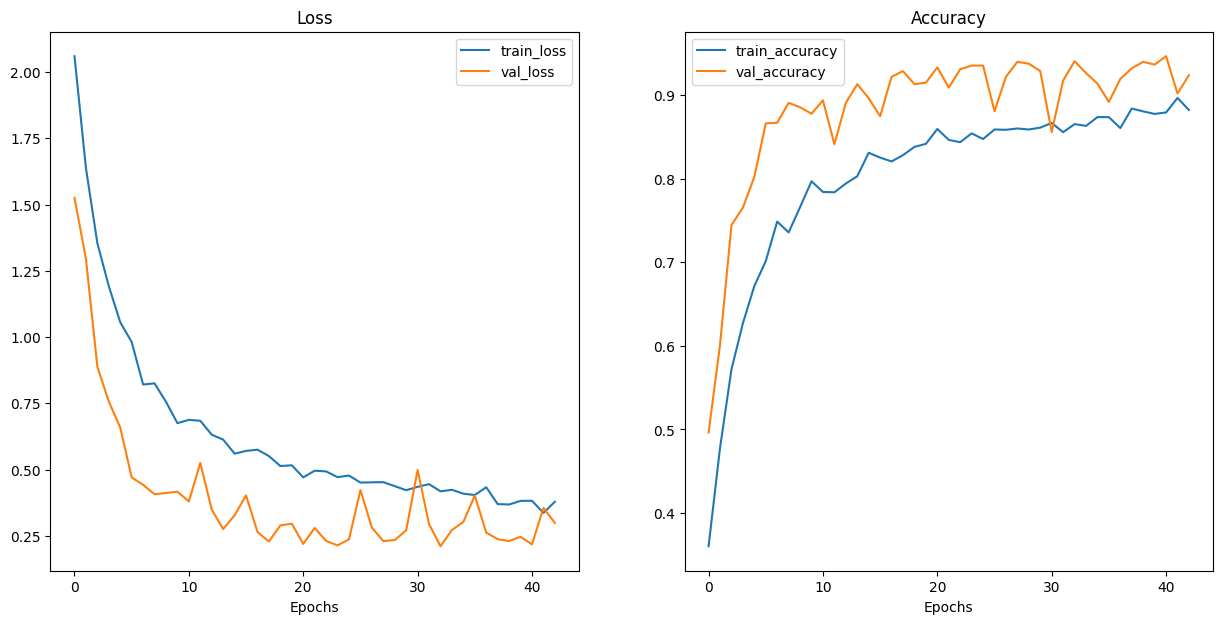

In [69]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and validation)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and validation)
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_result)

# Load model

In [70]:
# Define the model architecture
new_model = BrainTumorModelV0().to(device)

# Load saved weight
new_model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

## Evaluate the model on the test set

In [71]:
loss_fn = nn.CrossEntropyLoss()

def test(model, test_loader, criterion, device):
    # Set the evaluation mode
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Accumulate loss
            test_loss += loss.item()

            # Calculate the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Count the number of correct predictions
            correct += (predicted == labels).sum().item()

            # Count the total number of samples
            total += labels.size(0)

    # Calculate the average test loss and accuracy
    test_loss /= len(test_dataloader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

test_loss, test_accuracy = test(new_model, test_dataloader, loss_fn, device)
# Print the test loss and accuracy
print(f"Test Loss = {test_loss:.4f}, Accuracy = {test_accuracy:.4f}")

  0%|          | 0/14 [00:00<?, ?it/s]

Test Loss = 0.2563, Accuracy = 0.9438


## Print 10 samples

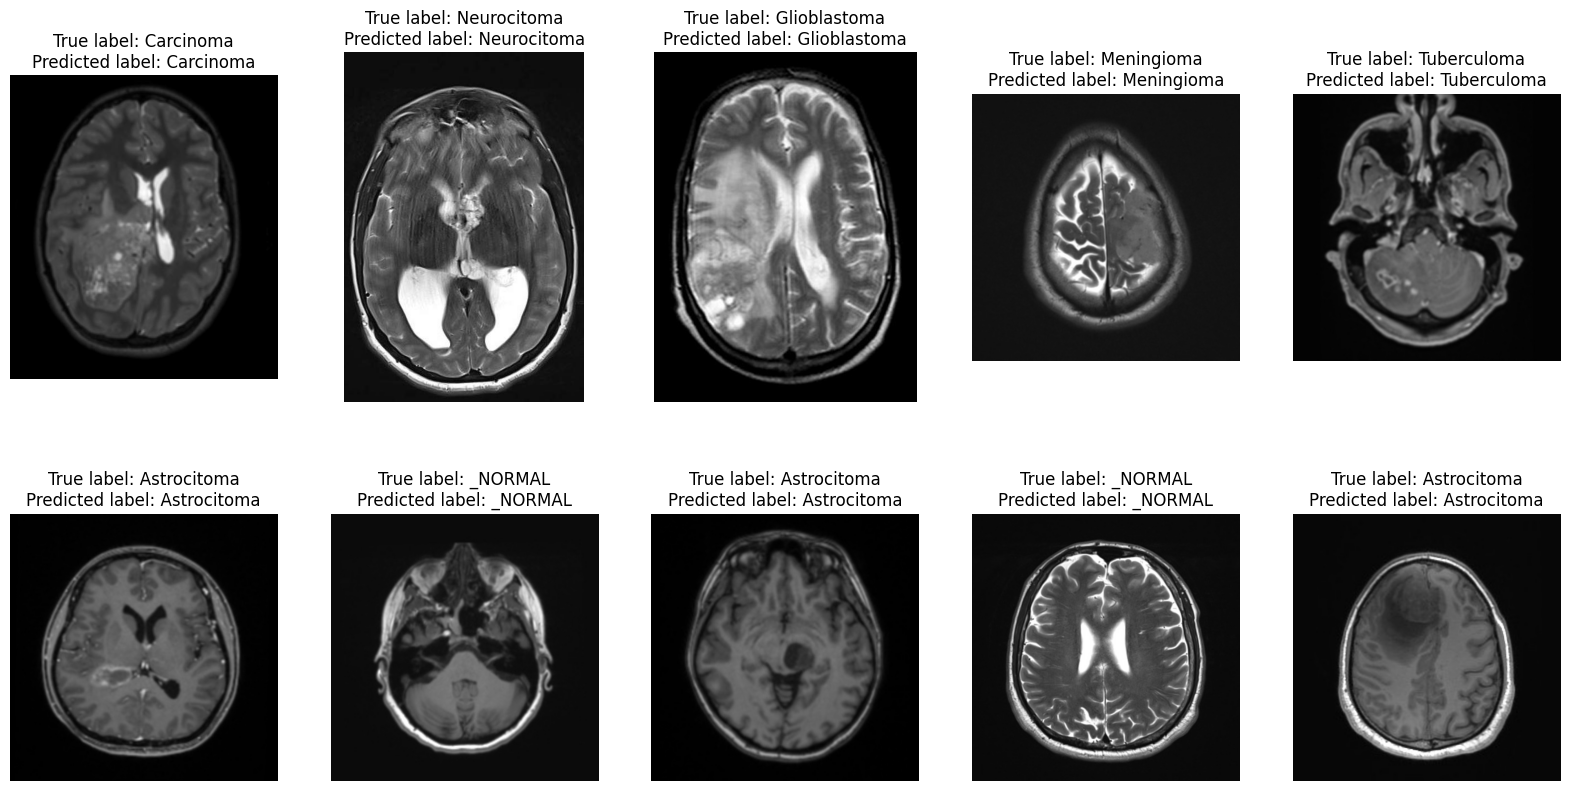

In [72]:
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')

# Define the number of images to display
num_images = 10

# Get a list of random indices for the test data
random_indices = np.random.choice(len(test_data), num_images, replace=False)

# Plot the images in 2 rows
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(num_images):
    # Get the i-th test image and true label
    img, true_label_idx = test_data[random_indices[i]]
    img_path = test_data.imgs[random_indices[i]][0]
    true_label = classes[true_label_idx]
    
    # Preprocess the image and convert to a batch of size 1
    img = img.unsqueeze(0)

    # Evaluate the model
    new_model.eval()
    with torch.no_grad():
        output = new_model(img.to(device))

    # Convert output probabilities to class labels
    _, pred_idx = torch.max(output, 1)
    pred_label = classes[pred_idx.item()]

    # Display the image and its true and predicted labels
    row = i // 5
    col = i % 5
    ax[row, col].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    ax[row, col].set_title(f'True label: {true_label}\nPredicted label: {pred_label}')
    ax[row, col].axis('off')

plt.show()